In [121]:
from matplotlib import pyplot as plt
from dataset import CamyleonDataset
from pathlib import Path
import random
import numpy as np
# from augmentations import Augmentations
# from masking import MaskingGenerator
import torch
from model import Model, init_model
from run_inference import infer_slide, remove_noise
from monai.data import WSIReader
import cv2
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
preprocessed_data_file = Path("/home/espenbfo/Documents/projects/dinov2_wsi/camelyon.hdf5")

sizes = (96, 224*1.5, 1024)

dataset = CamyleonDataset(preprocessed_data_file, is_train=False, sizes=sizes)
print(dataset.files)

INIT DATASET train False
{'masks': ['/home/espenbfo/datasets/camelyon/masks/patient_012_node_0_mask.tif', '/home/espenbfo/datasets/camelyon/masks/patient_001_node_3_mask.tif', '/home/espenbfo/datasets/camelyon/masks/patient_009_node_4_mask.tif', '/home/espenbfo/datasets/camelyon/masks/patient_043_node_3_mask.tif', '/home/espenbfo/datasets/camelyon/masks/patient_017_node_2_mask.tif', '/home/espenbfo/datasets/camelyon/masks/patient_009_node_1_mask.tif', '/home/espenbfo/datasets/camelyon/masks/patient_011_node_1_mask.tif', '/home/espenbfo/datasets/camelyon/masks/patient_034_node_3_mask.tif', '/home/espenbfo/datasets/camelyon/masks/patient_044_node_4_mask.tif', '/home/espenbfo/datasets/camelyon/masks/patient_021_node_3_mask.tif'], 'images': ['/home/espenbfo/datasets/camelyon/images/patient_012_node_0.tif', '/home/espenbfo/datasets/camelyon/images/patient_001_node_3.tif', '/home/espenbfo/datasets/camelyon/images/patient_009_node_4.tif', '/home/espenbfo/datasets/camelyon/images/patient_043_n

2
(224, 224, 3)


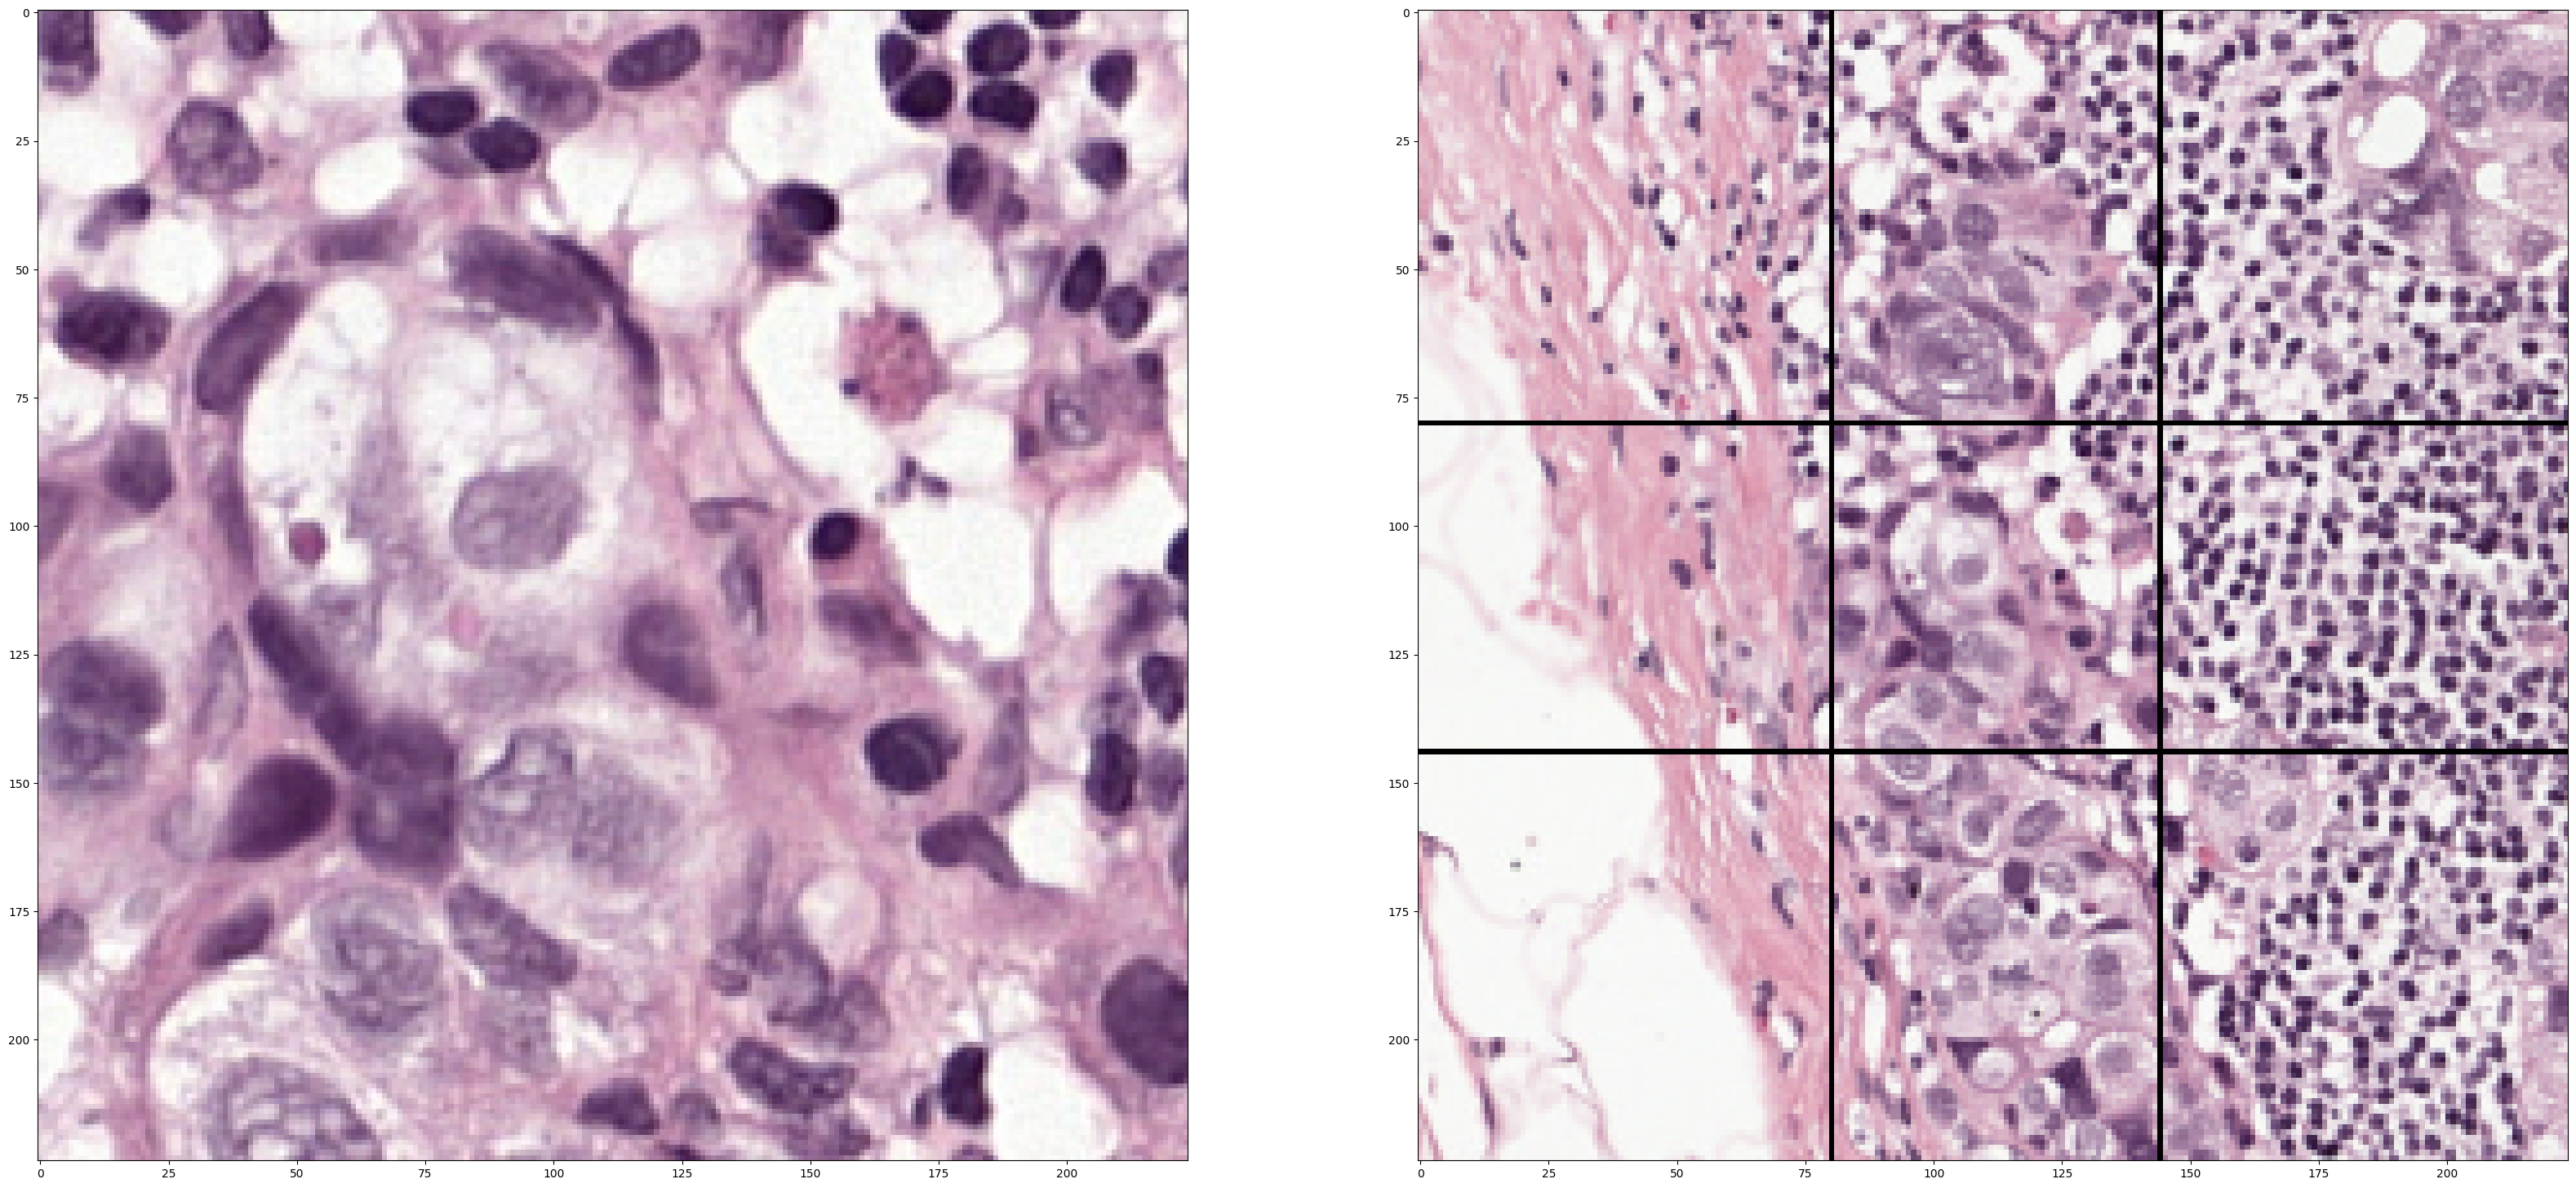

In [123]:
(image1, image2, _), label = dataset.__getitem__(2)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(40, 20))
image1 = np.moveaxis(image1.numpy(), 0, 2)
#image1[np.arange(224)%16==0]=0
#image1[:,np.arange(224)%16==0]=0
image2 = np.moveaxis(image2.numpy(), 0, 2)
image2[16*5]=0
image2[16*9]=0
image2[:,16*5]=0
image2[:,16*9]=0
image3 = image2[16*5:16*9, 16*5:16*9]

print(label)
print(image1.shape)
ax1.imshow(image1)
ax2.imshow(image2)


3


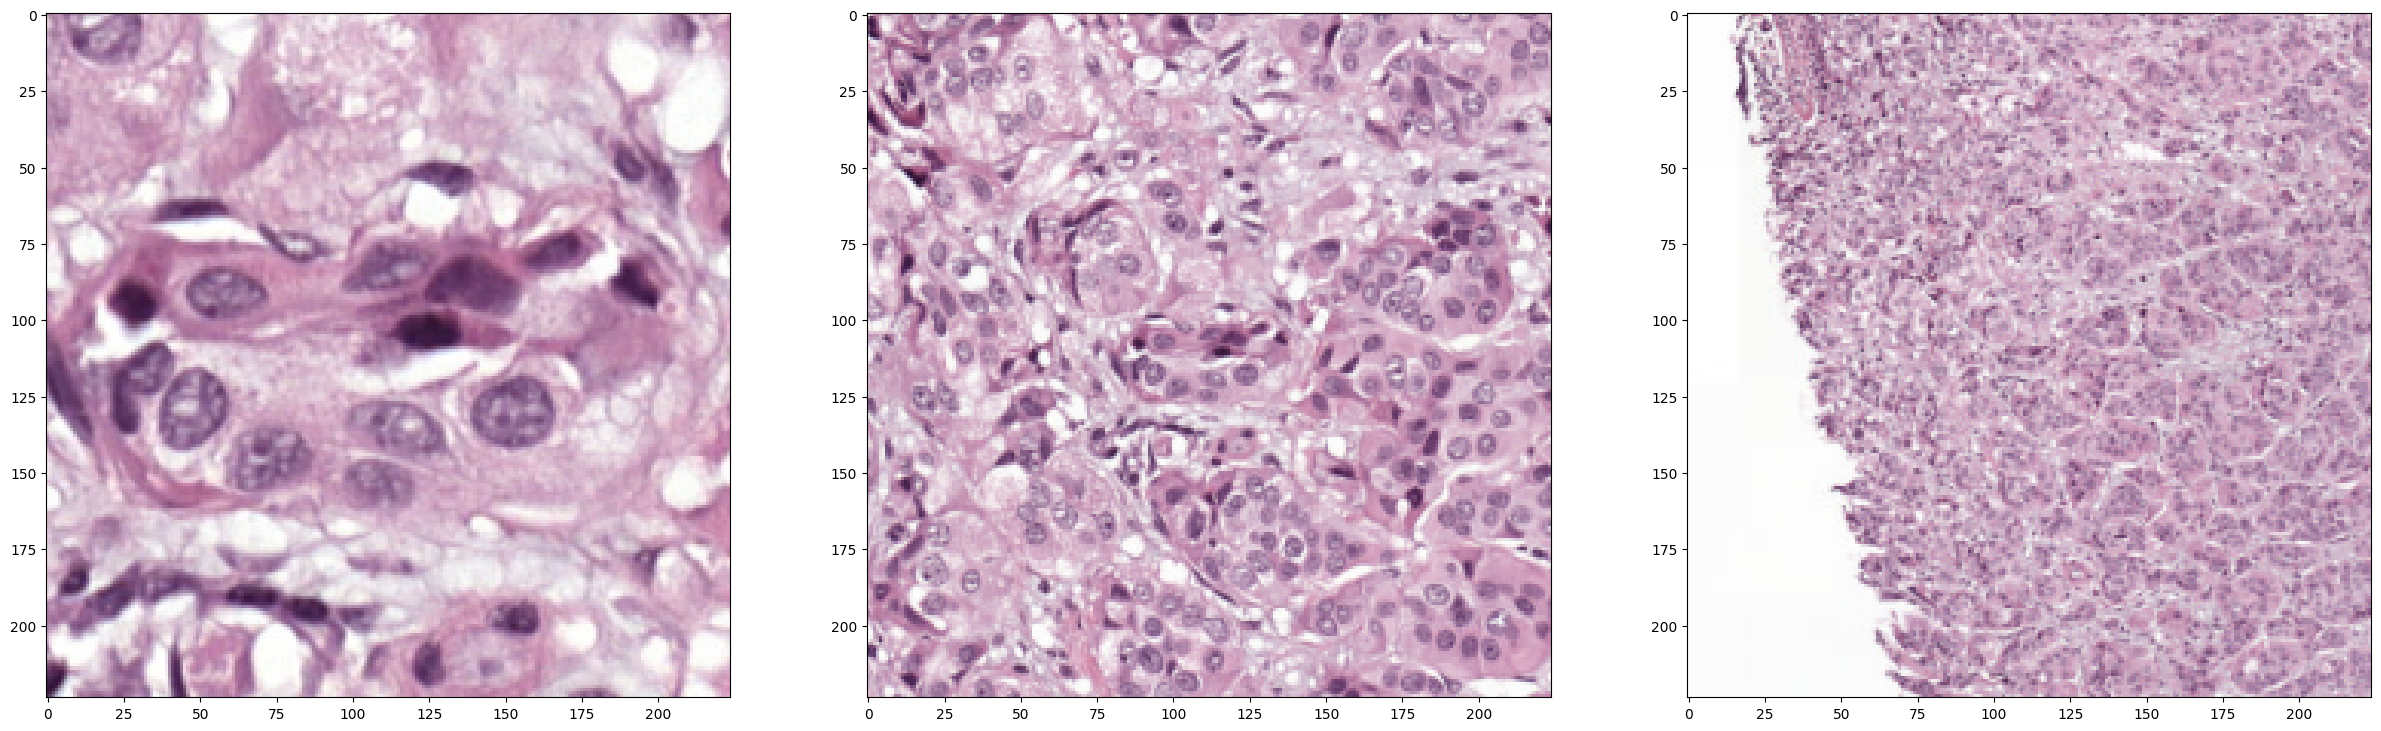

In [124]:
label = 2
index, key = dataset.label_to_index[label][0]
images = dataset.retrieve_patch_with_label(2, index, key, sizes=sizes)

fig, axes = plt.subplots(1,len(sizes), figsize=(10*len(sizes), 10))
print(len(images))
for i, ax in enumerate(axes):
    ax.imshow(np.moveaxis(images[i].numpy(), 0, 2))

In [125]:
model = init_model(2)
SIZES = (64, 224)
state_dict = torch.load(f"weights{'-'.join(map(lambda x: str(x), SIZES))}.pt")
model.load_state_dict(state_dict)

Embedding dimension: 768


<All keys matched successfully>

In [126]:
slide_id = 7
inference, ignored = infer_slide(dataset.files["images"][slide_id], 32, model.to("cuda"), distance_per_sample=1000/10, sizes=SIZES)

100%|█████████▉| 117501/117530 [25:24<00:00, 77.07it/s, std: 0.477] 


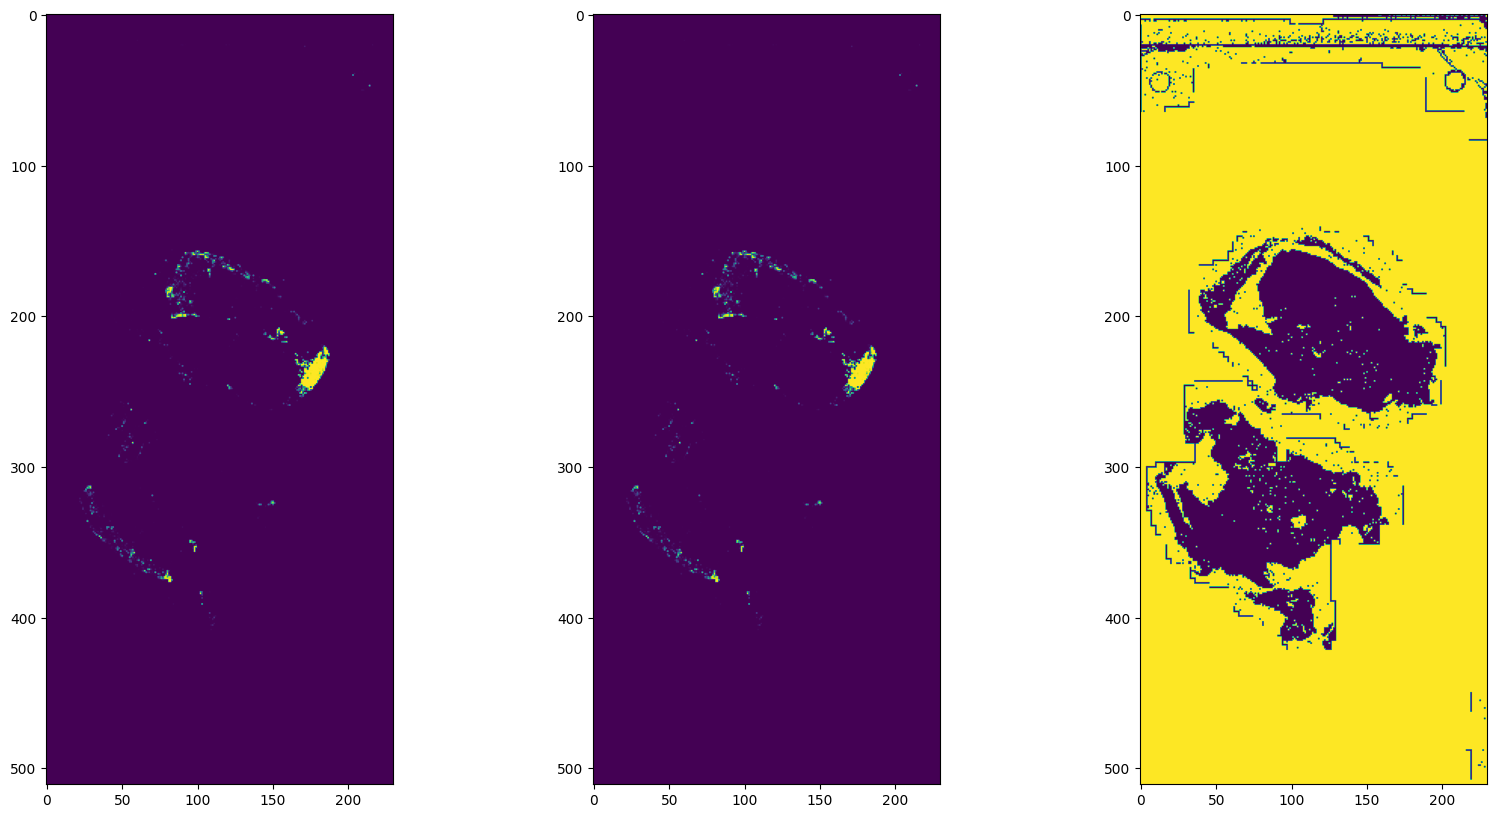

In [132]:
noise_constant = 1

inference_no_noise  =remove_noise(inference, noise_constant)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))


ax1.imshow(inference, vmin=0, vmax=1)
ax2.imshow(inference_no_noise, vmin=0, vmax=1)
ax3.imshow(ignored)

/home/espenbfo/datasets/camelyon/masks/patient_034_node_3_mask.tif
/home/espenbfo/datasets/camelyon/images/patient_034_node_3.tif
[0]


Text(0.5, 1.0, 'Slide image')

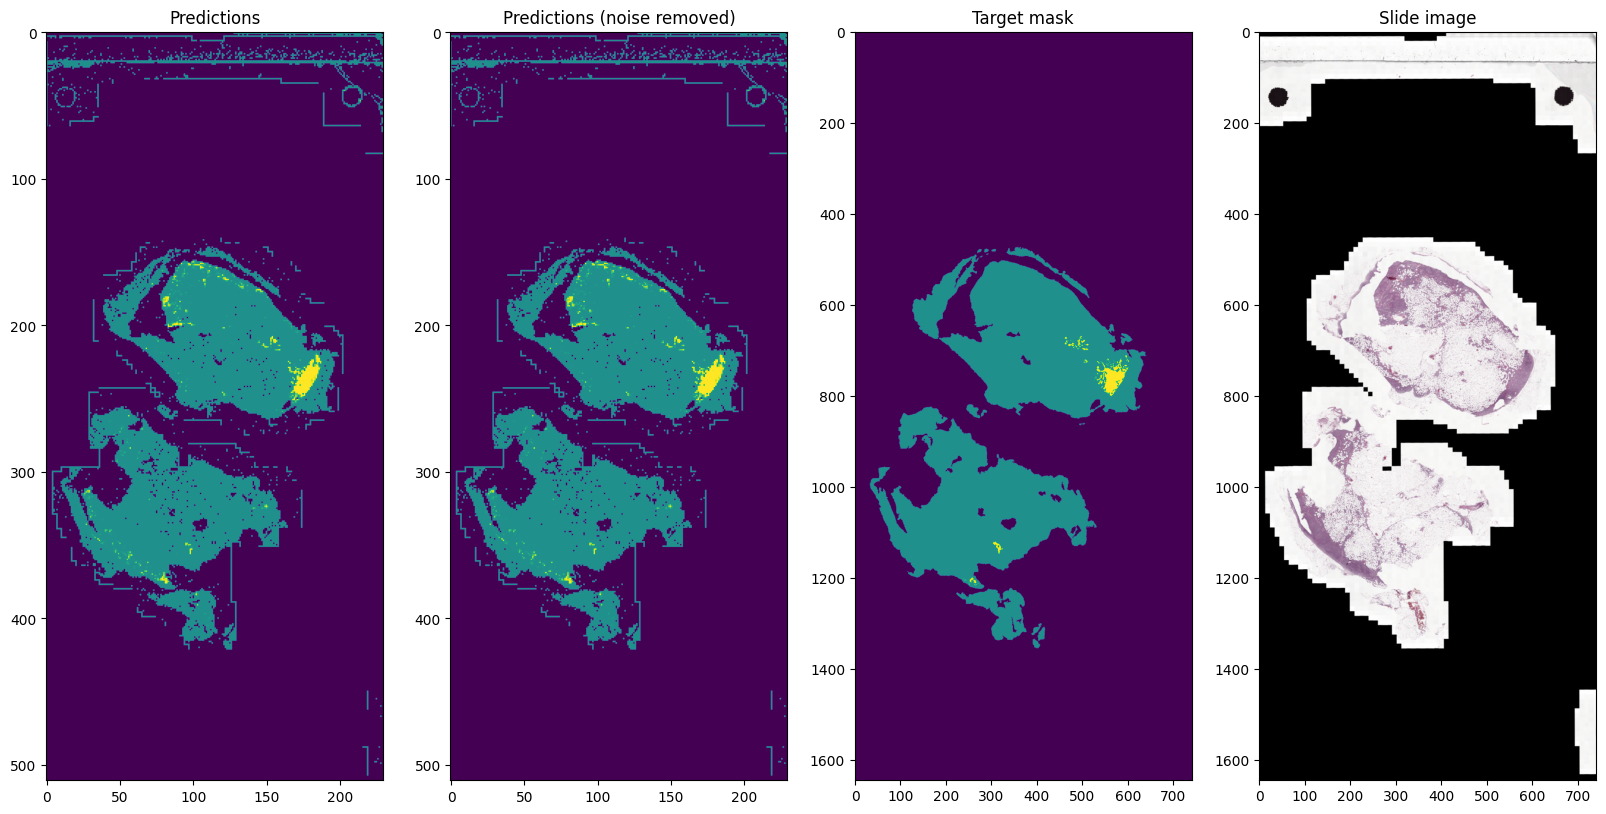

In [133]:
masked_file = dataset.files["masks"][slide_id]
image_file = dataset.files["images"][slide_id]
print(masked_file)
print(dataset.files["images"][slide_id])

masked_reader = WSIReader(backend="tifffile")
masked_file = masked_reader.read(masked_file)
mask = masked_reader.get_data(masked_file, level=7, mode="Å")[0][0]


image_reader = WSIReader(backend="cucim")
image_file = image_reader.read(image_file)
image = np.moveaxis(image_reader.get_data(image_file, level=7, mode="RGB")[0], 0, 2)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 10))
print(np.unique(mask[0]))
ax1.imshow(inference+1-ignored)
ax1.set_title("Predictions")
ax2.imshow(inference_no_noise+1-ignored)
ax2.set_title("Predictions (noise removed)")
ax3.imshow(mask)
ax3.set_title("Target mask")
ax4.imshow(image)
ax4.set_title("Slide image")

(511, 230)
Recall 0.7297474581830108
Precision 0.4623857024106401
Recall on negative predicions 0.9978723509247501
Balanced accuracy 0.8638099045538805
f1 score 0.56608573972777


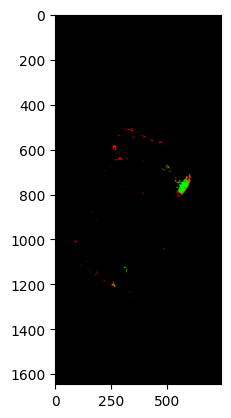

In [135]:
def balanced_accuracy(tp, fn, tn, fp):
    return (tp.sum()/(tp.sum()+fn.sum())+tn.sum()/(tn.sum()+fp.sum()))/2
threshold = 0.5
print(inference.shape)
inference_resized = np.round(cv2.resize((inference>threshold).astype(float), mask.shape[::-1])).astype(int)
out = np.zeros((*inference_resized.shape, 3))
out[:,:,1] = (mask==2)&(inference_resized==1)
out[:,:,0] = ((mask!=2)&(inference_resized==1))
plt.imshow(out)

true_positives = (mask==2)&(inference_resized==1)
false_negative = (mask==2)&(inference_resized!=1)

false_positive = (mask!=2)&(inference_resized==1)
true_negative = (mask!=2)&(inference_resized!=1)

n_positives = (mask==2).sum()
n_negatives = (mask!=2).sum()
n_predicted_positives = (inference_resized==1).sum()

precision = true_positives.sum()/(true_positives.sum()+false_positive.sum())
recall = true_positives.sum()/n_positives

print(f"Recall {recall}")
print(f"Precision {precision}")

print(f"Recall on negative predicions {true_negative.sum()/n_negatives}")

print(f"Balanced accuracy {balanced_accuracy(true_positives, false_negative, true_negative, false_positive)}")
print(f"f1 score {2/(1/recall+1/precision)}")


3


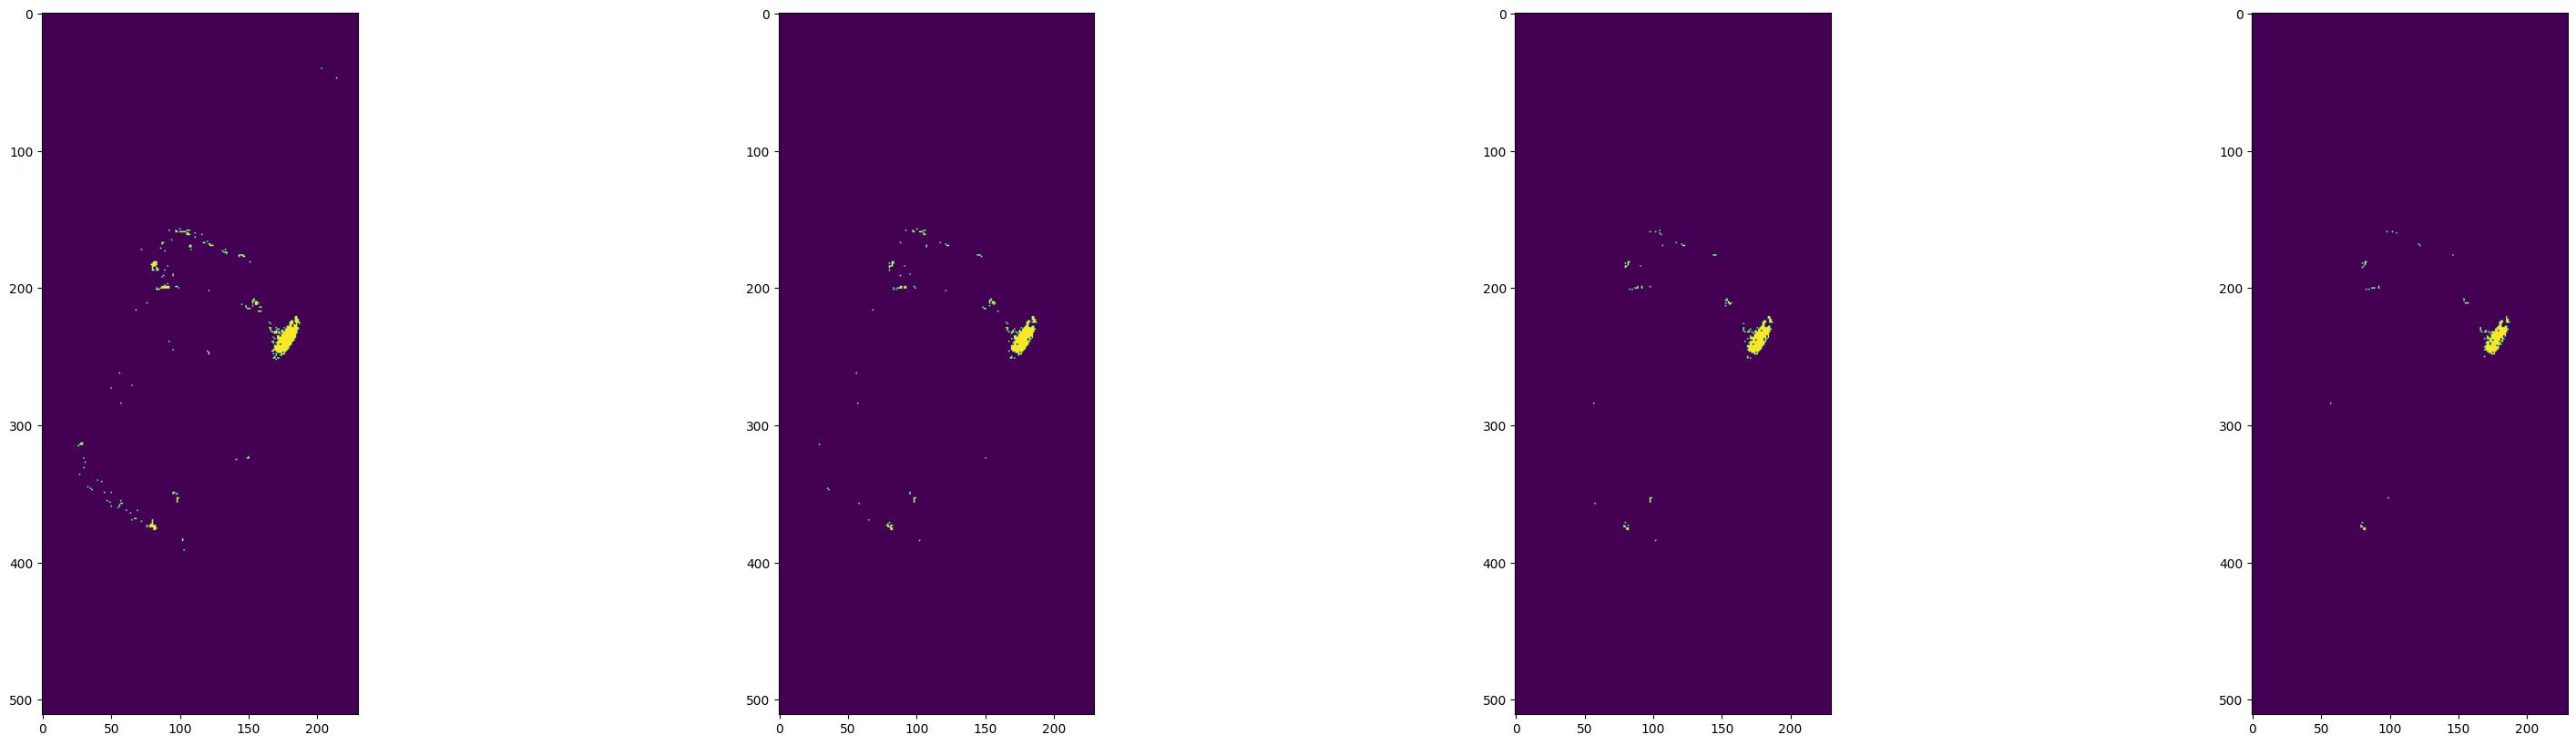

In [136]:
threshold = (0.5, 0.9, 0.95, 0.98)

fig, axes = plt.subplots(1,len(threshold), figsize=(10*len(threshold), 10))
print(len(images))
for i, ax in enumerate(axes):
    ax.imshow(inference>threshold[i])


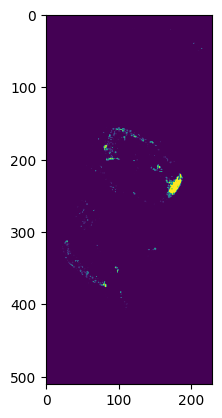

In [137]:
plt.imshow(inference)